## Camera Calibration

The steps involved in calibrating the camera is as follows :
<ul>
    <li> First we need to create a 3D grid of points according to the number of corners in the chess board. This is called as objp.</li>
    <li> Let objpoints and imgpoints be the 3D points in real world space and 2D points in image plane from top left to bottom right. </li>
    <li> Now we use a for loop to load each image and convert it to grayscale. </li>
    <li> Then we utilise the findChessboardCorners function to identify the pixel co-ordinates of the corners.</li>
    <li> If we are able to find the corners, ret is updated as true and we append objp into objpoints and corners into imgpoints. The for loop ends here.</li>
    <li> To obtain the camera matrix and distortion co-efficients, we use the calibrateCamera function and pass the imgpoints, objpoints and the shape of the image as arguments </li> 
    <li> To undistort any image, we can now use the undistort function with the camera matrix and distortion co-efficients</li>


</ul>

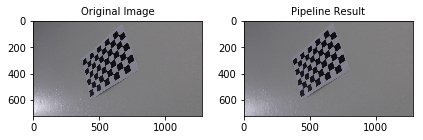

In [1]:
import numpy as np
import matplotlib.image as mpimg
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib qt
%matplotlib inline

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space from top left to bottom right
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

#initialise object points as zeros
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #creates grid points in x,y coordinates

# # Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         plt.imshow(img)

#dist = distortion coefficients, mtx = camera matrix matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,plt.imread(images[0]).shape[1::-1],None,None)

# undist is the image after undistorting using the camera matrix and distortion coefficients
undist = cv2.undistort(plt.imread(images[5]),mtx,dist,None,mtx)

f, (ax1,ax2) = plt.subplots(1, 2)

f.tight_layout()

ax1.imshow(plt.imread(images[5]),cmap='gray')
ax1.set_title('Original Image', fontsize=10)

ax2.imshow(undist,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=10)
f.savefig('camera_calib.png')

# Perspective transform and Threshold


In [2]:
class LaneLineDetector():
    def __init__(self):
        self.leftHist= None
        self.rightHist= None
        self.prev_leftHist= None
        self.prev_rightHist = None
        
    # Find the perspective transform of the image
    def Perspective(self,img):
        y=img.shape[0]
        x=img.shape[1]
        offset=300
        src = np.float32([[190, 720], [596, 447],[685, 447],[1125, 720]])
        dst = np.float32([[offset, y],[offset, 0],[x-offset, 0],[x-offset, y]])
        M = cv2.getPerspectiveTransform(src, dst)
        M_inv = cv2.getPerspectiveTransform(dst,src)
        return_image = cv2.warpPerspective(img, M, (x,y), flags=cv2.INTER_LINEAR)
        return return_image,M_inv
    
    def pre_process(self,image):
        s_thresh=(170, 255)
        sx_thresh=(30, 100)
        img = np.copy(image)

        ############ Now convert to HLS space and apply thresholds ##############

        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]

        # Sobel x
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

        ################# Return ###################

        return combined_binary   

    def find_lane_pixels(self,binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty
    
    def measure_curvature_meters(self,binary_warped, left_fitx, right_fitx, ploty):
        # Define conversions in x and y from pixels space to meters
        # Returns the curvature of the left and the right lane lines in meters
        
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2) #converted pixels to meters
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)

        # Calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_curverad, right_curverad


    def fit_polynomial(self,binary_warped,leftx, lefty, rightx, righty):
        # Fit a second order polynomial to each using `np.polyfit`. It does a least squares polyfit.
        left_fit = np.polyfit(lefty, leftx, 2) # returns the coefficients of the polynomial function
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]  #This is the value of the curve (not that imp)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            
        return left_fit, right_fit, left_fitx, right_fitx, ploty

    
    def search_around_poly(self,binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        return left_fit, right_fit, left_fitx, right_fitx, ploty
    
    def measure_position_meters(self,binary_warped, left_fit, right_fit):
        # Define conversion in x from pixels space to meters
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Choose the y value corresponding to the bottom of the image
        y_max = binary_warped.shape[0]
        # Calculate left and right line positions at the bottom of the image
        left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
        right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
        # Calculate the x position of the center of the lane 
        center_lanes_x_pos = (left_x_pos + right_x_pos)//2
        # Calculate the deviation between the center of the lane and the center of the picture
        # The car is assumed to be placed in the center of the picture
        # If the deviation is negative, the car is on the felt hand side of the center of the lane
        veh_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
        return veh_pos
    
    def show_lane(self,img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))

        # Combine the result with the original image
        out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        cv2.putText(out_img,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
        cv2.putText(out_img,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)

        return out_img

In [3]:
def main(image):
    L = LaneLineDetector()
#     image =mpimg.imread('test_images/test2.jpg')
    undistorted_img = cv2.undistort(image,mtx,dist,None,mtx)
    thresholded_img = L.pre_process(undistorted_img)
    transformed_img, inverse_transform = L.Perspective(thresholded_img)
    if L.rightHist== None:
        leftx, lefty, rightx, righty = L.find_lane_pixels(transformed_img)
        left_fit, right_fit, left_fitx, right_fitx, ploty = L.fit_polynomial(transformed_img,leftx, lefty, rightx, righty)
        L.leftHist = np.array(left_fit)
        new_left_fit = np.array(left_fit)
        L.leftHist = np.vstack([L.leftHist, new_left_fit])
        L.rightHist = np.array(right_fit)
        new_right_fit = np.array(right_fit)
        L.rightHist = np.vstack([L.rightHist, new_right_fit])
    else:
        L.prev_leftHist = [np.mean(L.leftHist[:,0]), np.mean(L.leftHist[:,1]), np.mean(L.leftHist[:,2])]
        L.prev_rightHist = [np.mean(L.rightHist[:,0]), np.mean(L.rightHist[:,1]), np.mean(L.rightHist[:,2])]
        leftx, lefty, rightx, righty = L.search_around_poly(binary_warped)
        if (len(lefty) == 0 or len(righty) == 0):
            leftx, lefty, rightx, righty = L.find_lane_pixels(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = L.fit_polynomial(transformed_img,leftx, lefty, rightx, righty)
        
        new_left_fit = np.array(left_fit)
        L.leftHist = np.vstack([L.leftHist, new_left_fit])
        new_right_fit = np.array(right_fit)
        L.rightHist = np.vstack([L.rightHist, new_right_fit])
        
        if (len(L.leftHist) > 10):
            left_fit_hist = np.delete(left_fit_hist, 0,0)
            right_fit_hist = np.delete(right_fit_hist, 0,0)
    
    left_curverad, right_curverad =  L.measure_curvature_meters(transformed_img, left_fitx, right_fitx, ploty)
    veh_pos = L.measure_position_meters(transformed_img, left_fit, right_fit) 
    out_img = L.show_lane(image,transformed_img, ploty, left_fitx, right_fitx,  inverse_transform, left_curverad, right_curverad, veh_pos)
    
    return out_img
    
    
video_output = 'project_video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(main)
%time output_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [04:06<00:00,  5.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 1min 47s, sys: 19.4 s, total: 2min 6s
Wall time: 4min 9s


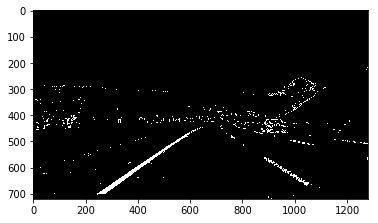

In [5]:
L = LaneLineDetector()
image = mpimg.imread('test_images/test3.jpg')
x = cv2.undistort(image,mtx,dist,None,mtx)
thresholded_img = L.pre_process(x)
transformed_img, inverse_transform = L.Perspective(thresholded_img)
plt.imshow(thresholded_img,cmap='gray')